# Getting started in Pandas and GeoPandas

This notebook shows the basics of [Pandas](https://pandas.pydata.org/index.html), a key Python package that is used to read, write, modify and analyze tabular data. The [DataFrame](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.html) type represents the tables in memory. At the end we also quickly show [GeoPandas](http://geopandas.org/), which combines Pandas and [Shapely](https://shapely.readthedocs.io/en/latest/), to allow also spatial joins and other kinds of geometric operations. So use Pandas to read a CSV file, and use GeoPandas to read a Shapefile.

First we will learn how to read in a CSV file, then how to retrieve parts of a DataFrame, followed by the [split-apply-combine](https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html) method of data processing. At the end we show GeoPandas.

In [1]:
import pandas as pd
import pathlib
import geopandas as gpd

In [2]:
%matplotlib inline

## Reading a CSV into Pandas

In this first example we will explore a CSV file, which contains information on worldwide reservoirs. First we can check it in a text editor to see the format. Since it is quite well formed, we can also load this directly in Excel.

First we use the standard library [pathlib](https://docs.python.org/3/library/pathlib.html) to represent the paths. This is more powerful than using things, as it allows you to do common path operations more easily.

In [3]:
datadir = pathlib.Path("data")
reservoir_path = datadir / "reservoir.csv"

To read a CSV file to a `pandas.DataFrame`, use [pandas.read_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.read_csv.html). It should allow you, by using it's many optional keyword arguments, to read pretty much any CSV file found in practice.

In [4]:
# read the file with default arguments, and use .head() to show only the first 5 rows
df_rv = pd.read_csv(reservoir_path)
df_rv.head()

,Grand_ID,Status Active Yes/No,"Max Level (m), HL","Max Surface Area (ha), HL","Max Surface Area (ha), JRC","Min Surface Area (ha), JRC","Normal Surface Area (ha), JRC",Count frequency Normal Area,"Max Capacity (Mcm), HL","Min Capacity (Mcm), GR","Normal Capacity (Mcm), GR","Main Use, GR",Water Province,HydroLakes_ID,Dam height [m]
0,0,NaN,13.4,51925,-99.000000,-99.0000,-99.00000,-99,6940.0,-99.0,-99.0,hydroelectricity,651,624,-99
1,1,NaN,32.3,412,395.066024,0.1449,18.09585,25,133.2,-99.0,-99.0,Hydroelectricity,1124,70379,59
2,2,NaN,57.9,9811,9725.462114,0.2075,9283.40450,55,5684.2,-99.0,264.8,Hydroelectricity,1122,3615,11
3,3,NaN,36.8,487,470.603354,0.0950,449.21570,76,179.1,-99.0,-99.0,Hydroelectricity,1124,72464,44
4,4,NaN,28.0,414,411.097963,0.0491,392.41310,67,115.9,-99.0,-99.0,Hydroelectricity,1124,72710,64


We can easily check the unique values in a column like so:

In [5]:
df_rv["Main Use, GR"].unique()

array(['hydroelectricity', 'Hydroelectricity', nan, 'Water supply',
       'Other', 'Recreation', 'Irrigation', 'Flood control', 'Fisheries',
       'Navigation'], dtype=object)

Above we can see that apparently -99 is used to represent missing data, and that in "Main Use, GR" the capitalisation is not consistent. We can lowercase this column to fix this. This can be done by specifying the keyword `converters`, and giving a dictionary that maps column names to functions that we want to apply to each element. The function for lowercasing is:

In [6]:
str.lower

<method 'lower' of 'str' objects>

In [7]:
"HyDrO".lower()

'hydro'

With these extra keyword arguments to `pandas.read_csv`, we get a `pandas.DataFrame` object that is ready for further analysis.

In [8]:
df = pd.read_csv(reservoir_path, na_values=-99,
                 converters={"Main Use, GR": str.lower})
df.head()

,Grand_ID,Status Active Yes/No,"Max Level (m), HL","Max Surface Area (ha), HL","Max Surface Area (ha), JRC","Min Surface Area (ha), JRC","Normal Surface Area (ha), JRC",Count frequency Normal Area,"Max Capacity (Mcm), HL","Min Capacity (Mcm), GR","Normal Capacity (Mcm), GR","Main Use, GR",Water Province,HydroLakes_ID,Dam height [m]
0,0,NaN,13.4,51925,NaN,NaN,NaN,NaN,6940.0,NaN,NaN,hydroelectricity,651,624,NaN
1,1,NaN,32.3,412,395.066024,0.1449,18.09585,25.0,133.2,NaN,NaN,hydroelectricity,1124,70379,59.0
2,2,NaN,57.9,9811,9725.462114,0.2075,9283.40450,55.0,5684.2,NaN,264.8,hydroelectricity,1122,3615,11.0
3,3,NaN,36.8,487,470.603354,0.0950,449.21570,76.0,179.1,NaN,NaN,hydroelectricity,1124,72464,44.0
4,4,NaN,28.0,414,411.097963,0.0491,392.41310,67.0,115.9,NaN,NaN,hydroelectricity,1124,72710,64.0


To select a subset of both the rows and the columns, we can use the [loc](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.loc.html) method. The syntax is as follows: `df.loc[rows, cols]`,  where `rows` and `cols` are one of the allowed inputs listed in the docs. In this case we use a boolean array to only select the rows which are `True`, and a list of column names to select only two columns.

In [9]:
df.loc[df["Dam height [m]"] > 20, ["Grand_ID", "Dam height [m]"]]

,Grand_ID,Dam height [m]
1,1,59.0
3,3,44.0
4,4,64.0
6,6,183.0
7,7,61.0
...,...,...
6790,6818,23.0
6793,6821,24.0
6794,6822,36.0
6795,6823,50.0


To write our DataFrame to a new CSV file, you can use the [DataFrame.to_csv](https://pandas.pydata.org/pandas-docs/stable/reference/api/pandas.DataFrame.to_csv.html) method. Here we set `index` to `False` to prevent adding an extra column with the row index, which here is just the the integer sequence starting at 1.

In [10]:
df.to_csv(datadir / "reservoir_out.csv", index=False)

## Split-apply-combine

Split-apply-combine, done in pandas and xarray through the use of the `groupby` function, is a powerful method to analyze a dataset, by reducing it to meaningful groups, and applying a function to each group independently, and combining the results back into a single data structure.

If you are familiar with Excel's pivot tables, they can be compared to them.

Specific documentation for `groupby` in pandas and xarray can be found here:
- https://pandas.pydata.org/pandas-docs/stable/user_guide/groupby.html
- http://xarray.pydata.org/en/stable/groupby.html

Doing a groupby gives an iterator over the groups that is not directly useful.

In [11]:
df.groupby("Main Use, GR")

We can iterate over the groups, and we get both the name and a dataframe of just that group back:

In [12]:
for use, group in df.groupby("Main Use, GR"):
    print(use)


fisheries
flood control
hydroelectricity
irrigation
navigation
other
recreation
water supply


In this case we can take the last group from the previous cell, and calculate the sum. This will attempt to take the sum of all columns, which for many of them, such as IDs and strings, will not make much sense.

In [13]:
group.sum()

Grand_ID                                                                   2453438
Status Active Yes/No                                                             0
Max Level (m), HL                                                            17626
Max Surface Area (ha), HL                                                   765331
Max Surface Area (ha), JRC                                                  392473
Min Surface Area (ha), JRC                                                 583.122
Normal Surface Area (ha), JRC                                               355913
Count frequency Normal Area                                                  54535
Max Capacity (Mcm), HL                                                      165323
Min Capacity (Mcm), GR                                                       22425
Normal Capacity (Mcm), GR                                                   115795
Main Use, GR                     water supplywater supplywater supplywater supp...
Wate

Making a box plot of the max capacity, we see that there are some very large outliers:

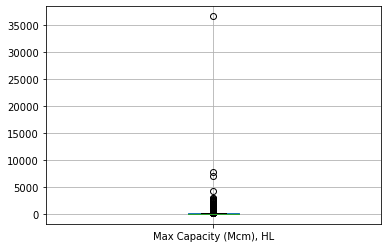

In [14]:
group[["Max Capacity (Mcm), HL"]].boxplot()

The value of the largest one can be retrieved with the max method.

In [15]:
group["Max Capacity (Mcm), HL"].max()

36700.0

If we want to find the use type with on average the highest capacities, we can do all this in one line:

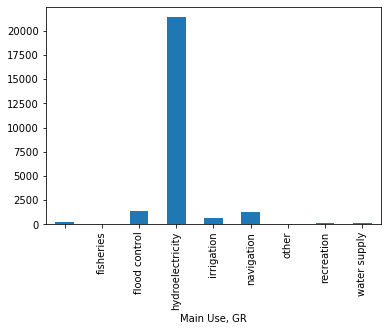

In [16]:
df.groupby("Main Use, GR").mean()["Max Capacity (Mcm), HL"].plot.bar()

When doing analysis like this it is important to keep into account how many data points we have per group. We can easily check that like so. Note that the brackets allow us to divide the expression over multiple lines, which can help readability.

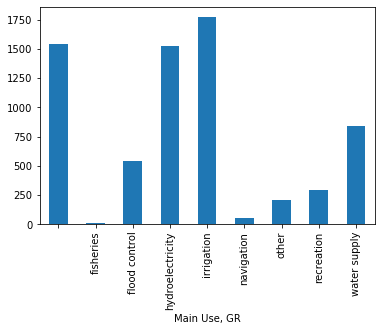

In [17]:
(df.groupby("Main Use, GR")["Grand_ID"]
 .count()
 .plot.bar()
)

### Exercise

- Which type of dam has on average the highest dam height?

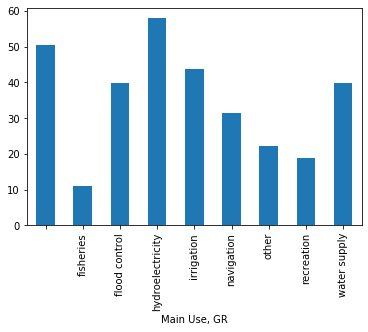

In [18]:
(df.groupby("Main Use, GR")["Dam height [m]"]
 .mean()
 .plot.bar()
)

- Investigate the relation between dam height and maximum capacity

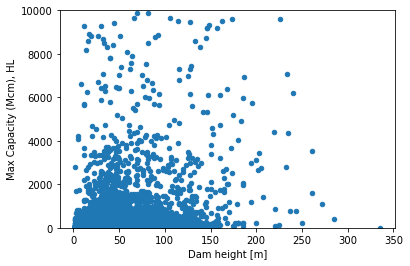

In [19]:
(df.plot.scatter(x="Dam height [m]",
  y="Max Capacity (Mcm), HL",
  ylim=(0.0, 1e4)
 ))

# GeoPandas

To work geospatial vector data like points and polygons with associated metadata, look into using GeoPandas, http://geopandas.org/.

Below we briefly show how it can used. We load a dataset with polygons and data of all countries that is included with geopandas. Note that it appears exactly like a `pandas.DataFrame` would, except this is a `geopandas.GeoDataFrame`, with special handling of the `geometry` column.

In [20]:
countries = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
countries

,pop_est,continent,name,iso_a3,gdp_md_est,geometry
0,920938,Oceania,Fiji,FJI,8374.0,"(POLYGON ((180 -16.06713266364245, 180 -16.555..."
1,53950935,Africa,Tanzania,TZA,150600.0,POLYGON ((33.90371119710453 -0.950000000000000...
2,603253,Africa,W. Sahara,ESH,906.5,POLYGON ((-8.665589565454809 27.65642588959236...
3,35623680,North America,Canada,CAN,1674000.0,"(POLYGON ((-122.84 49.00000000000011, -122.974..."
4,326625791,North America,United States of America,USA,18560000.0,"(POLYGON ((-122.84 49.00000000000011, -120 49...."
...,...,...,...,...,...,...
172,7111024,Europe,Serbia,SRB,101800.0,"POLYGON ((18.82982479287395 45.90887235802528,..."
173,642550,Europe,Montenegro,MNE,10610.0,"POLYGON ((20.07070000000004 42.58863000000008,..."
174,1895250,Europe,Kosovo,-99,18490.0,"POLYGON ((20.59024654668023 41.85540891928363,..."
175,1218208,North America,Trinidad and Tobago,TTO,43570.0,"POLYGON ((-61.68000000000001 10.76, -61.105 10..."


It also has geospatial plotting support, see http://geopandas.org/mapping.html for more information.

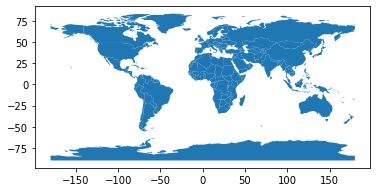

In [21]:
countries.plot()

To dissolve the geometries of the countries, we can directly dissolve based on the value of the continent column:

In [22]:
continents = countries.dissolve(by='continent')
continents

,geometry,pop_est,name,iso_a3,gdp_md_est
continent,,,,,
Africa,(POLYGON ((49.54351891459575 -12.4698328589405...,53950935,Tanzania,TZA,150600.0
Antarctica,(POLYGON ((-163.7128956777287 -78.595667413241...,4050,Antarctica,ATA,810.0
Asia,(POLYGON ((120.2950142762069 -10.2586499976035...,18556698,Kazakhstan,KAZ,460700.0
Europe,(POLYGON ((-51.65779741067889 4.15623240805302...,142257519,Russia,RUS,3745000.0
North America,"(POLYGON ((-61.68000000000001 10.76, -61.105 1...",35623680,Canada,CAN,1674000.0
Oceania,(POLYGON ((169.6678145693731 -43.5553256162263...,920938,Fiji,FJI,8374.0
Seven seas (open ocean),"POLYGON ((68.935 -48.62500000000001, 69.58 -48...",140,Fr. S. Antarctic Lands,ATF,16.0
South America,(POLYGON ((-66.95992000000001 -54.896810000000...,44293293,Argentina,ARG,879400.0
